# Terminal Link Optimization

This is the main ipython script for the terminal link optimization algorithm.
I will update the documentation accordingly once the project has progressed further.

## Import packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Make simulation of satellite and customers

Lets first start by simulating customers on the ground. This will essentially 
end up being a straight line with dots (representing customers) being randomly 
distributed along the line. The line will be spaced according to some 
arbitrary time metric. Each customer will have (for now) 4 attributes which 
describe the "importantness" of each customer.

In [0]:
"""
Lets make an array containing the physical location of some simulated customers.
The array will have the shape (N_time_segments,length_of_time_segment)

customer data array `customer_arr` will be of shape (number of training orbits, number of customers 
in orbit, number of features describing priority of customers)
"""

# training set hyperparameters
num_customers = 100 # total number of customers on planet
num_orbits = 10000  # total number of training samples (in this case orbits)
max_dist = 10000    # maximum distance allowed for customers
dist_step = 200     # distance traveled per step by satellite
obs_window = 200    # total size of observation window of satellite in units of distance
customer_arr = np.zeros((num_orbits,num_customers,5)) # Define emtpy array to contain customer data

# Make training set
for i in range(num_orbits):
    # Make customer index labels
    customer_arr[i,:,0] = np.arange(start=0,stop=num_customers,step=1)

    # Define random locations of customers on a line defining the planet
    customer_arr[i,:,1] = np.random.randint(low=0,high=max_dist,size=(num_customers))

    # Assign a random customer important factor. 0 == low importance, 1 == high importance
    customer_arr[i,:,2] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

    # Assign a random customer weather factor. 0 == high cloud coverage, 1 == low cloud coverage
    customer_arr[i,:,3] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

# Testing set hyperparameters
num_test_orbits = 100 # number of test samples to use
customer_test_arr = np.zeros((num_test_orbits,num_customers,5))

# Make test set
for i in range(num_test_orbits):
    # Make customer index labels
    customer_test_arr[i,:,0] = np.arange(start=0,stop=num_customers,step=1)

    # Define random locations of customers on a line defining the planet
    customer_test_arr[i,:,1] = np.random.randint(low=0,high=max_dist,size=(num_customers))

    # Assign a random customer important factor. 0 == low importance, 1 == high importance
    customer_test_arr[i,:,2] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

    # Assign a random customer weather factor. 0 == high cloud coverage, 1 == low cloud coverage
    customer_test_arr[i,:,3] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

## Choose optimal order in which to distribute keys (simple approach)

This is an incredibly simple algorithm which only takes into account 
the importantness and weather factors for each customer. It does not 
take into account the total time customers have been waiting for 
a key to be distributed to them.

In [0]:
# Loop over all available customers within line-of-sight (this is by default set to num_customers)
# This is an example using only one training orbit.
for i in range(num_customers):
    customer_arr[0,i,4] = customer_arr[0,i,2] * customer_arr[0,i,3]

customer_prob_list_idx = np.argsort(customer_arr[0,:,4])[::-1]
customer_prob_list = customer_arr[0,customer_prob_list_idx,0]

In [4]:
# Print out ordered list of customers to distribute keys to
customer_prob_list

array([75., 91., 10., 37., 86., 34., 38., 13., 16., 20., 28.,  5., 68.,
        7., 92., 72., 62., 67., 71., 89., 70., 31., 95., 53.,  0., 56.,
        3., 63.,  8., 57., 58., 17., 19., 76., 93., 22.,  6., 49., 59.,
       32., 88.,  2., 14., 64., 25., 61., 65., 80., 35., 99., 48., 33.,
       83., 81., 73.,  4., 26., 78., 54., 60., 36., 11., 39., 52., 27.,
       69., 21., 79., 24., 18., 12., 90., 46., 77., 50., 40., 42., 82.,
       47., 30., 43., 97.,  1., 87., 55., 66., 15., 74.,  9., 98., 45.,
       23., 29., 94., 41., 51., 44., 96., 84., 85.])

## Neural Network Approach (complicated approach)

I've written some pseudo code down on a piece of paper. Not guranteeing that 
this will actually work in practice, but I will make my first attempt of this here.

### Define network archetecture

In [13]:
# This approach uses the Pytorch neural network library

# neural network hyperparameters
number_epochs = 100
batch_size = 128

# Define network archetecture (convolutional neural network)
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (1,3), stride=1).double()
        self.conv2 = nn.Conv2d(32, 64, (1,3), stride=1).double()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(6144, 120).double()
        self.fc2 = nn.Linear(120, 84).double()
        self.fc3 = nn.Linear(84, num_customers).double() # one node for predicted probability

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        # If the size is a square you can only specify a single number
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.num_flat_features(x))
        # Two fully-connected hidden layers and one output layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
net.to(device)
print(net)

params = list(net.parameters())

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(1, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1))
  (fc1): Linear(in_features=6144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)


Need to fix loss function, such that it is differentiable. This can be done by 
scaling the loss calculated for each customer by the predicted probability 
associated with each customer. We would try to maximize the cost function associated with those who had keys distributed to them, rather than minimize the cost function associated with those who did not get keys distributed to them. See picture on your phone for more details.


In [0]:
def custom_loss(output, target, batch_feature_data):
    """ This is a custom loss function which 
    takes as input the raw output from the neural 
    network and returns a loss which attempts to 
    minimize the number of keys not distributed 
    within the alloted amount of time.
    """
    
    def my_model(output, batch_feature_data):
        """ This is a model which will iterate 
        over the predicted ordering of keys to be 
        distributed. There will be a penalty 
        associated with any keys which are predicted to 
        be distributed outside of the obersvation window.
        """

        # Assume 5 seconds to distribute key to customer downstream
        # Array to store the calculated number of keys lying outside of time alloted
        new_output = torch.zeros((batch_feature_data.shape[0],num_customers), requires_grad=True)

        # Iterate over all samples in batch
        for i in range(batch_feature_data.shape[0]):

          # Get predicted output for current sample in batch
          tmp_output = output[i,:]

          dist_cnt = 0
          # Satellite travels until maximum distance reached (defined as 1 orbit around Earth)
          while dist_cnt <= max_dist:       

            num_inside_dist = 0
            customers_in_cur_wind_prob = []
            customers_in_cur_wind_idx = []
            customers_in_cur_wind_feat = []

            # Iterate over all customers around the globe
            for customer_idx,customer in enumerate(batch_feature_data[i,:,:]):
 
              # If the location of a customer lies within the line-of-sight of satellite 
              if customer[0] < (dist_cnt + obs_window) and customer[0] > (dist_cnt):
                num_inside_dist += 1

                # Append predicted probability of key being distributed
                customers_in_cur_wind_prob.append(tmp_output[customer_idx])

                # Append the index of the customer
                customers_in_cur_wind_idx.append(customer_idx)

                # Append loss value of customer
                customers_in_cur_wind_feat.append(customer[1]*customer[2])

            # If there are no customers within the current line-of-sight, add some distance traveled to satellite
            if not customers_in_cur_wind_prob:
              dist_cnt+=dist_step
              continue
            
            # Of all customers within line-of-sight, choose one with max probability
            max_cust = customers_in_cur_wind_idx[np.argmax(customers_in_cur_wind_prob)]

            # Add to batch sample loss max prob customer weather and importantness scaled by predicted probability of key distribution
            new_output[i,max_cust] = torch.add(new_output[i,max_cust], (tmp_output[max_cust] * 
                                                          batch_feature_data[i,max_cust,1] *
                                                          batch_feature_data[i,max_cust,2]))
            
            # Add a distance traveled by satellite (dist_step)
            dist_cnt+=dist_step

           
          #print('Found %d cutomers inside required window of operation' % num_inside_dist)
    
        return torch.tensor(new_output, requires_grad=True)
    
    # Get number of keys predicted to be outside of target window
    pred_model_score = my_model(output, batch_feature_data)

    # Normalize score to be between zero and 1
    pred_model_score = torch.div( pred_model_score, torch.max(pred_model_score))
    #print(pred_model_score)

    loss = torch.mean((pred_model_score - torch.tensor(target, requires_grad=True))**2)
    return loss

### Run network over entire training set

In [0]:
# training features: location, importance, weather
X_train = customer_arr[:,:,1:4]
Y_train = np.ones((num_orbits,num_customers))

In [8]:
running_loss = 0.0
train_split = num_orbits

dset_train = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
dataloader = DataLoader(dset_train, batch_size=batch_size,
                        shuffle=True)

# Iterate over entire training set
for epoch_num in range(number_epochs):
    for i_batch, sampled_batch in enumerate(dataloader):
        print(i_batch)
        # in your training loop:
        if (train_split - (batch_size * i_batch)) < batch_size:
            break
        optimizer.zero_grad()   # zero the gradient buffers
        output = net(sampled_batch[0].reshape(batch_size,3,1,num_customers).to(device))
        loss = custom_loss(output, Y_train[i_batch:i_batch+batch_size].reshape(batch_size,num_customers), sampled_batch[0])
        loss.backward()
        optimizer.step()    # Does the update to the network
        #print('Finished a batch')
        print('loss: %.3f' %
          (loss.item()))    
        
    
    
    print('Training epoch %d/%d' % (epoch_num+1,number_epochs))
    # print statistics
    print('loss: %.3f' %
          (loss.item()))

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


loss: 0.884
1
loss: 0.890
2
loss: 0.889
3
loss: 0.888
4
loss: 0.888
5
loss: 0.892
6
loss: 0.892
7
loss: 0.891
8
loss: 0.889
9
loss: 0.890
10
loss: 0.891
11
loss: 0.892
12
loss: 0.890
13
loss: 0.887
14
loss: 0.891
15
loss: 0.887
16
loss: 0.889
17
loss: 0.890
18
loss: 0.892
19
loss: 0.888
20
loss: 0.889
21
loss: 0.892
22
loss: 0.890
23
loss: 0.887
24
loss: 0.890
25
loss: 0.889
26
loss: 0.890
27
loss: 0.889
28
loss: 0.888
29
loss: 0.890
30
loss: 0.889
31
loss: 0.888
32
loss: 0.888
33


KeyboardInterrupt: ignored

### Plot Results

In [0]:
with torch.no_grad():

    # Get test predictions from trained neural network
    test_preds = net(torch.tensor(customer_test_arr[:,:,1:4].reshape(num_test_orbits,3,1,num_customers)))

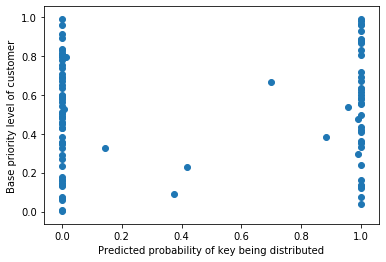

In [11]:
# Make scatter plot of priority as a function of key dist probability
plt.scatter(test_preds[0,:].detach().numpy(),customer_test_arr[0,:,2])
plt.xlabel('Predicted probability of key being distributed')
plt.ylabel('Base priority level of customer')
plt.show()

In [0]:
plt.close()